# Recalibrated Restaurant Rating Based On Sentiment Analysis - Part 1

<img src="https://static1.squarespace.com/static/5b1590a93c3a53e49c6d280d/t/5fd058bf5efba8153b21ad7f/1607489731350/restaurant-reviews-16x9.jpg?format=1500w" alt="Image Alt Text">

## Project Overview
How important is star rating, or online reviews, for a small business, such as restaurant?

According to a study, 88% of consumers read online reviews to decide whether to experience or purchase a business' product or service. And, 94% of consumers will not do a business with a company due to negative online reviews.

Amongst variety of different online review platforms (e.g., Yelp, TripAdvisor, Facebook), Google has the greatest power as it holds ~90% of search traffic.

Considering the aforementioned facts, it is crucial for a business/company to maintain a positive Google rating for its business to thrive.

However, Google's star rating system can be arbitrary as reviewers all hold different criteria for providing certain number of stars. In this regard, this project aims to conduct sentiment analysis to determine whether Google's star rating system is relatively accurate/objective based on the sentiment scores of each review.

*Source: Digital Air Strike*

## Business Problem
Google Maps Product Manager received many complaints from restaurant owners that Google rating system is quite inconsistent and arbitrary in that many restaurants are either over or under-rated by its customers despite similar quality of food, atmostphere, and service.

For this reason, the PM would like to investigate whether the complaints are valid (or substantiated by data). If the claim is true, the PM is considering updating Google Maps' star rating system by auto-assigning stars based on each customer's review instead of user-assigned star rating system.

To make a data-driven decision, the PM has engaged Sangwon, data scientist, for the analysis.

*Note: This business problem is hypothetical; not based on actual complaint*

## Data Understanding
### Data Overview
For this project, Google Maps review dataset was pulled from Google Maps API:

- Each API data pull returns ~300 reviews (5 reviews per restaurant) for a given location (e.g., Chelsea)
- Since the Google Maps API provides random ~300 reviews at a time, there may be duplicates in each pull
- Since the API only provides the latest 5 reviews per restaurant, the star ratings composition is imbalanced as user has no control over the review selections

Overall, for this project, I have pulled roughly ~3K reviews along with restaurant information to minimize API usage cost and computing time.

### Data Limitations
- Due to the limited computational power, the model will be trained on a relatively small dataset
- The dataset does not have all/full text reviews for a given restaurant (i.e., limited to 5 reviews per restaurant)
- The dataset exclusively examines reviews of New York City restaurants. Different geography may have quite different relationship between text review's sentiment score and star rating

In [ ]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
# Looking into the file structure
from google.colab import drive
drive.mount('/content/gdrive')

sample_view = pd.read_csv('gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews.csv')
sample_view.head()

Mounted at /content/gdrive


,id,name,address,rating,author,text,review_rating
0,1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5
1,2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4
2,3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4
3,4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4
4,5,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4


## Data Preparation
Output from the Google Maps API provides quite clean dataset. Hence, we will be doing minimal data cleansing and pre-processing.

Sentiment analysis model does not require tokenizing, stemming, and lemmatizing as the models rely on pre-built lexicon that contains sentiment scores.

In addition, please note that this notebook was run on Google Colab environment as it was more suitable to run advanced LLM/NLP models from HuggingFace.

In [ ]:
# Merging all data files
file_paths = ['gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews.csv',
              'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_1.csv',
             'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_2.csv',
              'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_3.csv',
             'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_4.csv',
              'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_5.csv',
              'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_6.csv',
              'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_7.csv',
              'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_8.csv',
              'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_9.csv',
             'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_10.csv',
              'gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/data/NYC_Restaurants_Reviews_11.csv']

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each file path and read CSV into a DataFrame
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Drop original id column
merged_df = merged_df.drop(columns=['id'])

# Print the merged DataFrame
merged_df

,name,address,rating,author,text,review_rating
0,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5.0
1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4.0
2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4.0
3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4.0
4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4.0
...,...,...,...,...,...,...
2915,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yur Mumz,"20 years ago, this was one of the better, of t...",3.0
2916,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yevgeniya Pechenaya,This was my first time here or eating pho in g...,5.0
2917,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Wuttichai Kailum,My friend and I went to this Vietnamese restau...,4.0
2918,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Jenny Yang,The pho was good but the service is horrible. ...,2.0


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2920 non-null   object 
 1   address        2920 non-null   object 
 2   rating         2920 non-null   object 
 3   author         2919 non-null   object 
 4   text           2909 non-null   object 
 5   review_rating  2919 non-null   float64
dtypes: float64(1), object(5)
memory usage: 137.0+ KB


In [ ]:
# Dropping null values
merged_df = merged_df.dropna()
merged_df

,name,address,rating,author,text,review_rating
0,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5.0
1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4.0
2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4.0
3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4.0
4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4.0
...,...,...,...,...,...,...
2915,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yur Mumz,"20 years ago, this was one of the better, of t...",3.0
2916,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yevgeniya Pechenaya,This was my first time here or eating pho in g...,5.0
2917,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Wuttichai Kailum,My friend and I went to this Vietnamese restau...,4.0
2918,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Jenny Yang,The pho was good but the service is horrible. ...,2.0


In [ ]:
# Dropping duplicates in case there are any duplications in the restaurant review data pull
cleaned_df = merged_df.drop_duplicates()
cleaned_df

,name,address,rating,author,text,review_rating
0,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5.0
1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4.0
2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4.0
3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4.0
4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4.0
...,...,...,...,...,...,...
2915,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yur Mumz,"20 years ago, this was one of the better, of t...",3.0
2916,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yevgeniya Pechenaya,This was my first time here or eating pho in g...,5.0
2917,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Wuttichai Kailum,My friend and I went to this Vietnamese restau...,4.0
2918,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Jenny Yang,The pho was good but the service is horrible. ...,2.0


In [ ]:
# Match ID with index number
cleaned_df = cleaned_df.reset_index()
cleaned_df

,index,name,address,rating,author,text,review_rating
0,0,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5.0
1,1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4.0
2,2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4.0
3,3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4.0
4,4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4.0
...,...,...,...,...,...,...,...
2904,2915,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yur Mumz,"20 years ago, this was one of the better, of t...",3.0
2905,2916,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yevgeniya Pechenaya,This was my first time here or eating pho in g...,5.0
2906,2917,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Wuttichai Kailum,My friend and I went to this Vietnamese restau...,4.0
2907,2918,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Jenny Yang,The pho was good but the service is horrible. ...,2.0


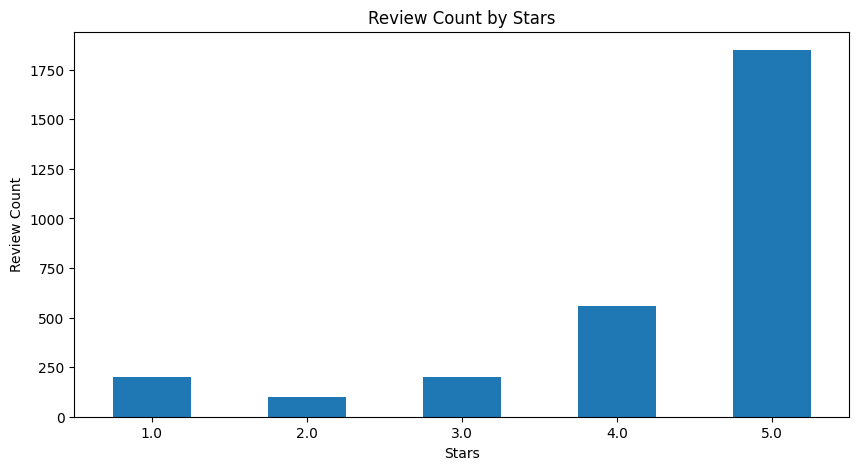

In [ ]:
# Star Rating Distribution
cleaned_df['review_rating'].value_counts().sort_index().plot(kind='bar', title='Review Count by Stars',
                                                             figsize=(10, 5), rot=0)
plt.xlabel('Stars')
plt.ylabel('Review Count');

In [ ]:
# Mean, Median, Mode of Star Reviews
mean = round(cleaned_df['review_rating'].mean(),1)
median = cleaned_df['review_rating'].median()

print('Mean star rating for the dataset is:   ', mean)
print('Median star rating for the dataset is: ', median)

Mean star rating for the dataset is:    4.3
Median star rating for the dataset is:  5.0


In [ ]:
# Number of unique restaurants
cleaned_df['name'].nunique()

563

In [ ]:
# Number of reviewers - there are some who wrote more than one review
cleaned_df['author'].nunique()

2606

##### Observations
- Most of the reviews are 4-5 stars, which is in line with my research that Google reviews tend to be inflated and generally positive

## Analysis
For the project, we will be using two different sentiment analysis model:
1. VADER (baseline sentiment analysis model)
2. Roberta (sentiment analysis model from HuggingFace, which should be more robust)

Both models provide sentiment score for a given review.

### Vader Model

In [ ]:
# VADER sentiment analysis model
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Example of review with emoji 
example = cleaned_df['text'][32]
example

'Attention and friendly service. Spicy mala rice noodle soup is simply so delicious. The soup base was well seasoned with fresh sliced beef, lettuce 🥬, wood ears mushroom, sweet corns, tofu and half of egg cooked in perfection.\n\nA great spot for a quick bite and dishes are in very generous portions and very well priced considering the location.'

In [ ]:
# Regular example of review
example2 = cleaned_df['text'][101]
example2

'Love it!  I had Lengua, El Pastor, spicy pork, they all tasted great and authentic street tacos!  I didn’t care about the service, the lady was kinda delayed serving we even without people waiting.  Anyway I was there for the taste and that ain’t changing my desire eating there.'

In [ ]:
# Running VADER model for an example review
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.9815}

In [ ]:
sia.polarity_scores(example2)

{'neg': 0.028, 'neu': 0.714, 'pos': 0.258, 'compound': 0.9346}

In [ ]:
# Checking actual rating of example review
example_rating = cleaned_df['review_rating'][32]
example_rating

5.0

In [ ]:
example_rating = cleaned_df['review_rating'][101]
example_rating

5.0

In [ ]:
# For loop to put VADER sentiment score for each review
review_text = {}
counter = 0

for review in cleaned_df['text']:
    id_new = counter
    counter += 1
    review_text[id_new] = sia.polarity_scores(review)

In [ ]:
# Converting the dictionary to dataframe to combine with our existing df
vader = pd.DataFrame(review_text).T

vader_table = cleaned_df.join(vader, how='inner')
vader_table

,index,name,address,rating,author,text,review_rating,neg,neu,pos,compound
0,0,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5.0,0.000,0.753,0.247,0.9775
1,1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4.0,0.078,0.700,0.222,0.8760
2,2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4.0,0.015,0.896,0.089,0.8360
3,3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4.0,0.067,0.746,0.187,0.8987
4,4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4.0,0.000,0.871,0.129,0.8820
...,...,...,...,...,...,...,...,...,...,...,...
2904,2915,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yur Mumz,"20 years ago, this was one of the better, of t...",3.0,0.099,0.837,0.064,-0.6249
2905,2916,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yevgeniya Pechenaya,This was my first time here or eating pho in g...,5.0,0.027,0.750,0.223,0.9343
2906,2917,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Wuttichai Kailum,My friend and I went to this Vietnamese restau...,4.0,0.016,0.812,0.172,0.9634
2907,2918,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Jenny Yang,The pho was good but the service is horrible. ...,2.0,0.193,0.696,0.112,-0.6757


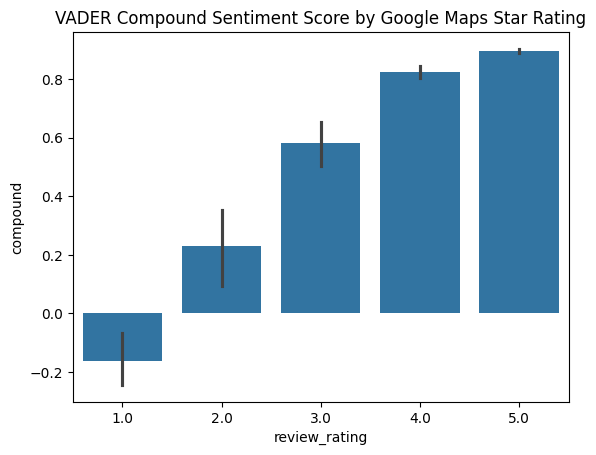

In [ ]:
# Seaborn barplot gives out mean of compound score for each review rating bucket
ax = sns.barplot(data=vader_table, x='review_rating', y='compound')
ax.set_title('VADER Compound Sentiment Score by Google Maps Star Rating');

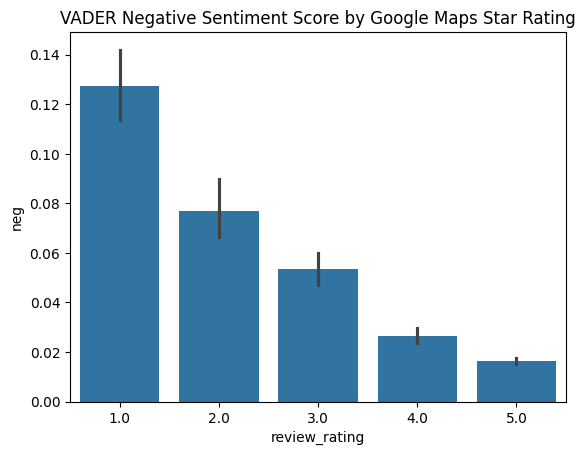

In [ ]:
ax = sns.barplot(data=vader_table, x='review_rating', y='neg')
ax.set_title('VADER Negative Sentiment Score by Google Maps Star Rating');

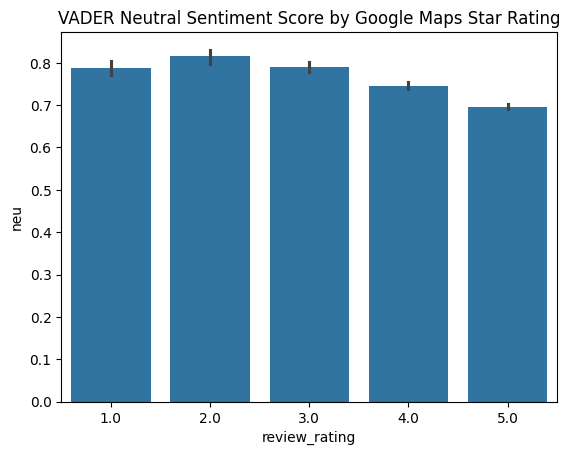

In [ ]:
ax = sns.barplot(data=vader_table, x='review_rating', y='neu')
ax.set_title('VADER Neutral Sentiment Score by Google Maps Star Rating');

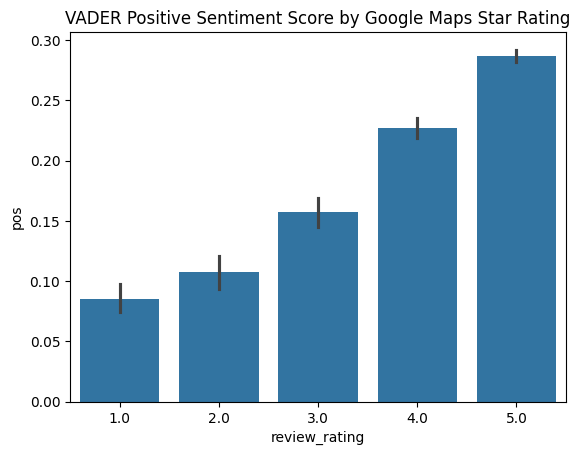

In [ ]:
ax = sns.barplot(data=vader_table, x='review_rating', y='pos')
ax.set_title('VADER Positive Sentiment Score by Google Maps Star Rating');

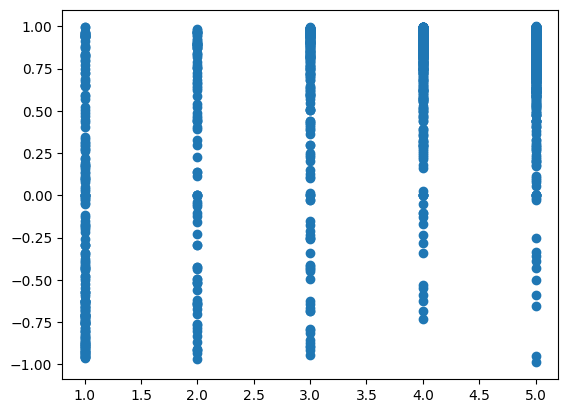

In [ ]:
# Creating clean df for scatter plot - seems like there are some instances where high compound scores for low star
# rating and low compound score for high star ratings
vader_table_clean = vader_table[['compound','review_rating']]
fig, ax = plt.subplots()
ax.scatter(vader_table_clean['review_rating'], vader_table_clean['compound']);

##### Observations
- On the aggregated level, VADER model's sentiment scores provide quite clear distinction among different star ratings
- Yet, on the individual level, there are a lot of noises as you can see from the scatter plot. Some 5 star reviews have very low VADER compound score and vice versa for the 1 star reviews

In [ ]:
# Checking for 1 customer review, but with high Vader compound score
vader_table_clean[vader_table_clean['review_rating']==1]

,compound,review_rating
10,0.7251,1.0
11,0.3472,1.0
14,-0.8429,1.0
35,0.9432,1.0
72,0.8743,1.0
...,...,...
2831,-0.9228,1.0
2842,0.9556,1.0
2846,-0.4324,1.0
2889,-0.6588,1.0


In [ ]:
vader_table.head(20)

,index,name,address,rating,author,text,review_rating,neg,neu,pos,compound
0,0,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5.0,0.000,0.753,0.247,0.9775
1,1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4.0,0.078,0.700,0.222,0.8760
2,2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4.0,0.015,0.896,0.089,0.8360
3,3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4.0,0.067,0.746,0.187,0.8987
4,4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4.0,0.000,0.871,0.129,0.8820
5,5,Little Italy Pizza,"2047 Broadway, New York, NY 10023, USA",3.9,Elizabeth TraubHarris,The smells of pizza draw you in. When you walk...,5.0,0.000,0.822,0.178,0.8910
6,6,Little Italy Pizza,"2047 Broadway, New York, NY 10023, USA",3.9,Thomas Mauriello,Narrow little local pizzaria serving delicious...,5.0,0.035,0.835,0.131,0.7717
7,7,Little Italy Pizza,"2047 Broadway, New York, NY 10023, USA",3.9,A.C.G,I don’t know if this pizza place was having a ...,2.0,0.090,0.751,0.159,0.5251
8,8,Little Italy Pizza,"2047 Broadway, New York, NY 10023, USA",3.9,Sooz Fitzpatrick,I regularly pick up a plain slice for my husba...,4.0,0.057,0.646,0.297,0.8834
9,9,Little Italy Pizza,"2047 Broadway, New York, NY 10023, USA",3.9,Beycan KIRBAÇ,pizzas are delicious and satisfying. I tried 3...,4.0,0.000,0.796,0.204,0.5187


In [ ]:
# VADER model does not pick up on sarcasm. Let's check if Roberta model does better job.
vader_table['text'][10]

'You’re paying $9  for the fancy truck to get ripped off with mediocre food, barely any chicken and a ton of raw onions after on top to create an illusion. The guy also shouting talking on phone preparing your food spit flying out his mouth. So many better other options near. Never again'

In [ ]:
example3 = 'You’re paying $9  for the fancy truck to get ripped off with mediocre food, barely any chicken and a ton of raw onions after on top to create an illusion. The guy also shouting talking on phone preparing your food spit flying out his mouth. So many better other options near. Never again'

sia.polarity_scores(example3)

{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.7251}

##### Observation
- An example of VADER model providing incorrect sentiment score. The above review is very negative, yet it does not pick up on it at all. This shows limitation of the VADER model.

Now, let's check if the Roberta model shows better performance.

### Roberta Model

In [ ]:
# Roberta package import
from transformers import AutoTokenizer, AutoConfig
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
# Using the latest Roberta sentiment model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Testing Roberta Model for Example Text
encoded_input = tokenizer(example, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dic = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]}
print(scores_dic)

# To remind ourselves, the VADER model score for example was: {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.9815}

{'roberta_neg': 0.003975193, 'roberta_neu': 0.015989935, 'roberta_pos': 0.98003495}


In [ ]:
# Testing Roberta Model for Example Text
encoded_input = tokenizer(example2, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dic = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]}
print(scores_dic)

# To remind ourselves, the VADER model score for example2 was: {'neg': 0.028, 'neu': 0.714, 'pos': 0.258, 'compound': 0.9346}

{'roberta_neg': 0.011635479, 'roberta_neu': 0.030706886, 'roberta_pos': 0.95765764}


In [ ]:
# Testing if Roberta Model can pick up sarcasm
example3 = 'You’re paying $9  for the fancy truck to get ripped off with mediocre food, barely any chicken and a ton of raw onions after on top to create an illusion. The guy also shouting talking on phone preparing your food spit flying out his mouth. So many better other options near. Never again'

encoded_input = tokenizer(example3, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dic = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]}
print(scores_dic)

# To remind ourselves, the VADER model score for example3 was: {'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.7251}


{'roberta_neg': 0.9464218, 'roberta_neu': 0.04816074, 'roberta_pos': 0.0054173884}


In [ ]:
# Testing another poor review but with relatively decent Vader score
example4 = vader_table['text'][7]
print(sia.polarity_scores(example4))

encoded_input = tokenizer(example4, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dic = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]}
print(scores_dic)

{'neg': 0.09, 'neu': 0.751, 'pos': 0.159, 'compound': 0.5251}
{'roberta_neg': 0.5443747, 'roberta_neu': 0.34249794, 'roberta_pos': 0.113127306}


##### Observations
- Here, it seeems like Roberta model performs much better than VADER model for the given example reviews

In [ ]:
def polarity_score_roberta(example):
  encoded_input = tokenizer(example, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dic = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]}
  return scores_dic

In [ ]:
polarity_score_roberta(cleaned_df['text'][314])

{'roberta_neg': 0.0059446027,
 'roberta_neu': 0.013156524,
 'roberta_pos': 0.98089886}

In [ ]:
# Putting the Roberta model result in dictionary format - took 17.5min
review_text_rb = {}
counter_rb = 0

for review in cleaned_df['text']:
    try:
      id_new = counter_rb
      counter_rb += 1
      review_text_rb[id_new] = polarity_score_roberta(review)
    except RuntimeError:
      print(f'Broke for id {id_new}')

Broke for id 376
Broke for id 614
Broke for id 810
Broke for id 1428
Broke for id 1754
Broke for id 2034
Broke for id 2105
Broke for id 2194
Broke for id 2237
Broke for id 2499
Broke for id 2575


In [ ]:
# Adding Roberta result to the dataframe
roberta = pd.DataFrame(review_text_rb).T

roberta_table = vader_table.join(roberta, how='left')
roberta_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2909 non-null   int64  
 1   name           2909 non-null   object 
 2   address        2909 non-null   object 
 3   rating         2909 non-null   object 
 4   author         2909 non-null   object 
 5   text           2909 non-null   object 
 6   review_rating  2909 non-null   float64
 7   neg            2909 non-null   float64
 8   neu            2909 non-null   float64
 9   pos            2909 non-null   float64
 10  compound       2909 non-null   float64
 11  roberta_neg    2898 non-null   float32
 12  roberta_neu    2898 non-null   float32
 13  roberta_pos    2898 non-null   float32
dtypes: float32(3), float64(5), int64(1), object(5)
memory usage: 284.2+ KB


In [ ]:
# Drop rows with null Roberta values
roberta_table.dropna(inplace=True)
roberta_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2898 entries, 0 to 2908
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2898 non-null   int64  
 1   name           2898 non-null   object 
 2   address        2898 non-null   object 
 3   rating         2898 non-null   object 
 4   author         2898 non-null   object 
 5   text           2898 non-null   object 
 6   review_rating  2898 non-null   float64
 7   neg            2898 non-null   float64
 8   neu            2898 non-null   float64
 9   pos            2898 non-null   float64
 10  compound       2898 non-null   float64
 11  roberta_neg    2898 non-null   float32
 12  roberta_neu    2898 non-null   float32
 13  roberta_pos    2898 non-null   float32
dtypes: float32(3), float64(5), int64(1), object(5)
memory usage: 305.6+ KB


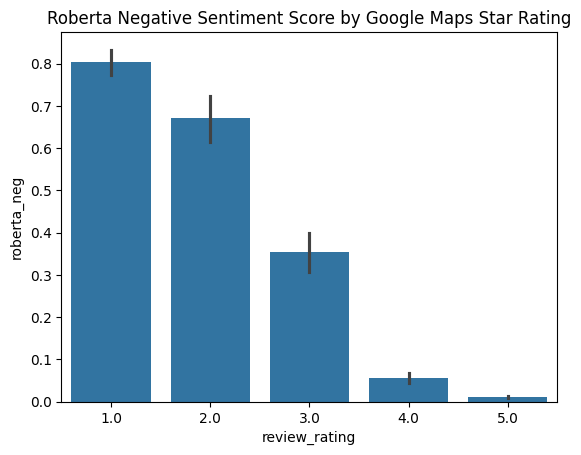

In [ ]:
ax = sns.barplot(data=roberta_table, x='review_rating', y='roberta_neg')
ax.set_title('Roberta Negative Sentiment Score by Google Maps Star Rating');

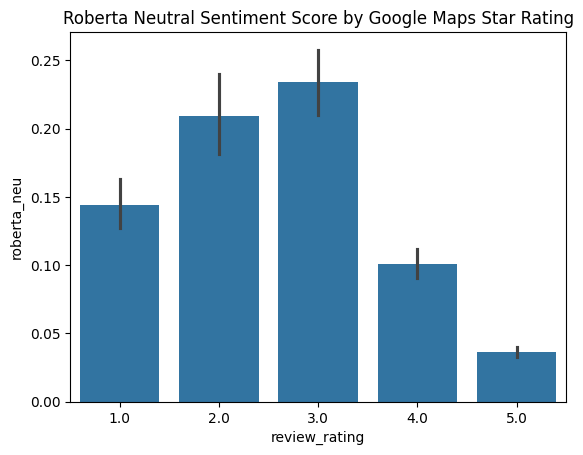

In [ ]:
ax = sns.barplot(data=roberta_table, x='review_rating', y='roberta_neu')
ax.set_title('Roberta Neutral Sentiment Score by Google Maps Star Rating');

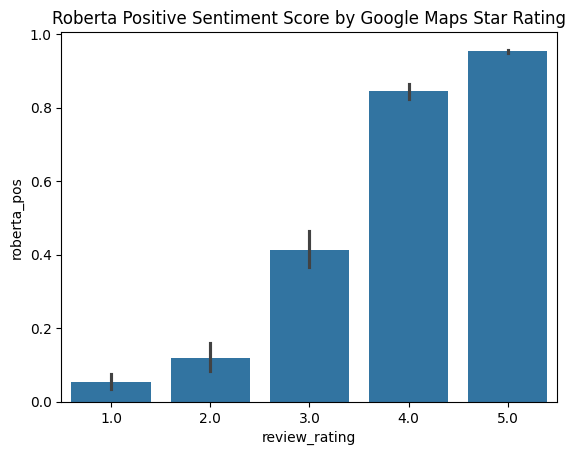

In [ ]:
ax = sns.barplot(data=roberta_table, x='review_rating', y='roberta_pos')
ax.set_title('Roberta Positive Sentiment Score by Google Maps Star Rating');

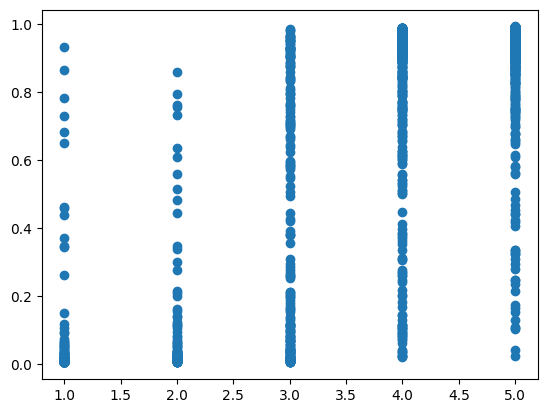

In [ ]:
# Scatter Plot 1 - Roberta Positive
fig, ax = plt.subplots()
ax.scatter(roberta_table['review_rating'], roberta_table['roberta_pos']);

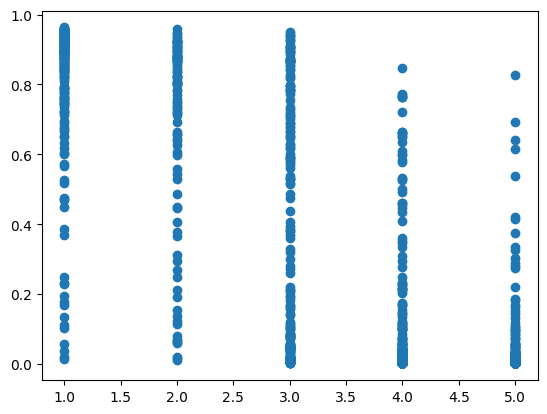

In [ ]:
# Scatter Plot 2 - Roberta Negative
fig, ax = plt.subplots()
ax.scatter(roberta_table['review_rating'], roberta_table['roberta_neg']);

##### Observations
- Compared to the VADER model, Roberta model, on aggregated level, shows even bigger distinction among the star buckets, especially for the positive and negative score
- For the neutral score, VADER model had relatively even bars across all star ratings. Yet, for the Roberta model, it shows peak in 3 Star bucket, which makes intuitive sense as 3 star rating should be a relatively a neutral review
- When evaluating the scatter plot, Roberta scatter plot does bit better than that of VADER model in that I see more clear clustering for the 1,2,5 star rating reviews. Yet, there appears to be many instances where 5 star ratings still have low positive or high negative Roberta scores. This may mean either the user was providing very generous star rating despite negative text reviews or the model is incorrectly calculating the sentiment score. We will need to further investigate this. 

In [ ]:
# Created arbitrary Roberta Compound Score
roberta_table['roberta_compound'] = roberta_table['roberta_neg'] *-1.5 + roberta_table['roberta_neu']*.5 + roberta_table['roberta_pos']
roberta_table

,index,name,address,rating,author,text,review_rating,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,roberta_compound
0,0,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Julia NORTHCOTT,My husband and I went off the tourist track an...,5.0,0.000,0.753,0.247,0.9775,0.002522,0.015262,0.982216,0.986063
1,1,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,dave I,4/13/24 first time here. Cool bar vibe. Intere...,4.0,0.078,0.700,0.222,0.8760,0.016963,0.195437,0.787600,0.859874
2,2,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Daniel Pino,"Layout/atmosphere\n*Bar (old, worn in wood) to...",4.0,0.015,0.896,0.089,0.8360,0.030593,0.765973,0.203433,0.540530
3,3,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,CA Hyde,Stopped by before a show at The Beacon. Good b...,4.0,0.067,0.746,0.187,0.8987,0.034314,0.211283,0.754403,0.808574
4,4,Amsterdam Ale House,"340 Amsterdam Ave, New York, NY 10024, USA",4.3,Steve Dempsey,Not the first time here and it's a good local ...,4.0,0.000,0.871,0.129,0.8820,0.004406,0.057676,0.937918,0.960147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904,2915,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yur Mumz,"20 years ago, this was one of the better, of t...",3.0,0.099,0.837,0.064,-0.6249,0.047834,0.366659,0.585506,0.697084
2905,2916,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Yevgeniya Pechenaya,This was my first time here or eating pho in g...,5.0,0.027,0.750,0.223,0.9343,0.004970,0.046438,0.948592,0.964356
2906,2917,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Wuttichai Kailum,My friend and I went to this Vietnamese restau...,4.0,0.016,0.812,0.172,0.9634,0.047065,0.541629,0.411306,0.611523
2907,2918,Phở Grand,"277C Grand St, New York, NY 10002, USA",4.1,Jenny Yang,The pho was good but the service is horrible. ...,2.0,0.193,0.696,0.112,-0.6757,0.945948,0.048085,0.005968,-1.388911


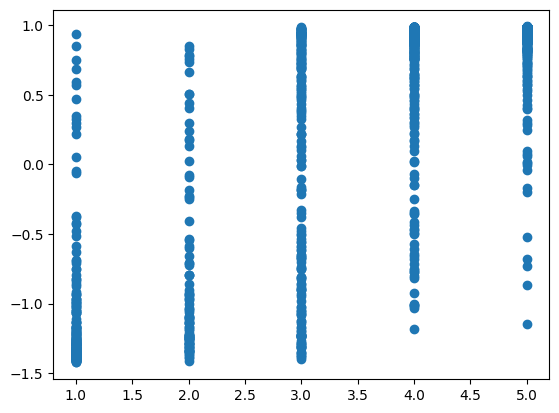

In [ ]:
fig, ax = plt.subplots()
ax.scatter(roberta_table['review_rating'], roberta_table['roberta_compound']);

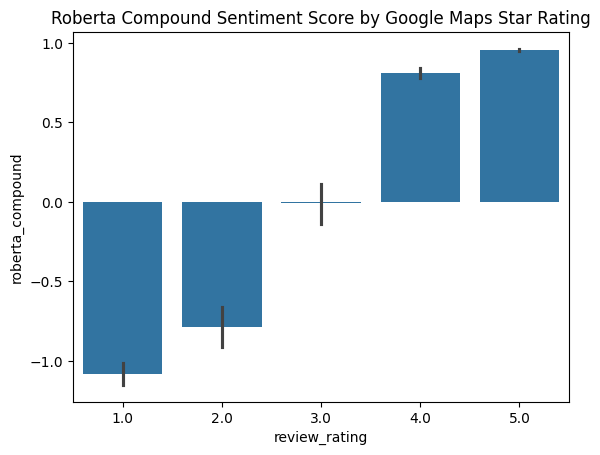

In [ ]:
ax = sns.barplot(data=roberta_table, x='review_rating', y='roberta_compound')
ax.set_title('Roberta Compound Sentiment Score by Google Maps Star Rating');

##### Observation
Roberta model does not provide a compound score like VADER model. Hence, I've created a compound score with custom weights to each score. And this is what I've noticed:
- I do see improvement compared to the VADER compound score's scatter plot in that I see better clustering for the non-neutral reviews (i.e., 1,2,4,5 star rating buckets)
- However, again, there appears to be some instances where 5 star ratings have quite low compound score and vice versa for 1 star ratings. We will need to manually check to see whether the model is correctly picking up or not

In [ ]:
roberta_table[roberta_table['review_rating']==1]['roberta_compound'].value_counts().sort_index()

roberta_compound
-1.423367    1
-1.418197    1
-1.415350    1
-1.413545    1
-1.412723    1
            ..
 0.591004    1
 0.684728    1
 0.753510    1
 0.855337    1
 0.939318    1
Name: count, Length: 196, dtype: int64

In [ ]:
roberta_table[(roberta_table['review_rating']==1) & (roberta_table['roberta_compound']>.5)]

,index,name,address,rating,author,text,review_rating,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,roberta_compound
927,930,STK Steakhouse,"26 Little W 12th St, New York, NY 10014, USA",4.7,Nikol Hristova,"The staff was amazing, very professional, made...",1.0,0.040,0.849,0.112,0.8341,0.135053,0.183699,0.681248,0.570518
1133,1137,Shake Shack Meatpacking District,"820 Washington St, New York, NY 10014, USA",4.2,Dwayne Noel,Today was my first time going to this Shake Sh...,1.0,0.084,0.869,0.047,-0.9368,0.020050,0.717743,0.262207,0.591004
1177,1181,Makito,"Gansevoort St, New York, NY 10014, USA",3.5,Jenn Rupp,We’re from Seattle & are very picky about our ...,1.0,0.177,0.699,0.124,-0.6261,0.055766,0.214152,0.730082,0.753510
1529,1533,Osteria Laguna,"209 E 42nd St, New York, NY 10017, USA",4.4,Michael Zmuda Trzebiatowski,I never left any place without a tip.\nThat wa...,1.0,0.083,0.760,0.157,0.8867,0.038470,0.096978,0.864552,0.855337
1742,1747,Mama Pho,"900 2nd Ave, New York, NY 10017, USA",3.7,Mad Joe,2nd time here and will not return. 1st experi...,1.0,0.125,0.760,0.115,-0.0090,0.103506,0.113011,0.783482,0.684728
2630,2640,Hong Man,"27 Eldridge St E, New York, NY 10002, USA",2.3,Jeffrey McRoberts,Delicious dumplings were only surpassed by the...,1.0,0.073,0.615,0.313,0.6486,0.013558,0.053575,0.932867,0.939318


In [ ]:
# Roberta model still not perfectly capturing relatively nuanced negative reviews (Roberta compound score of .68)
roberta_table['text'].iloc[1738]

"2nd time here and will not return.  1st experience was amazing.  I had a tofu sandwich and it was fresh.  Simply delicious.  I returned today craving same sandwich and experience.  There was only 1 worker doing both the register and cooking.  Tofu was stale, and only 3 cube pieces per sandwich half, bread was extra hard and toasted.  They also charged me 11.50 + tax for this terrible sandwich.  Worker seemed overwhelmed, didn't smile and restaurant needed cleaning up.  Completely opposite experience from my first visit.  What a shame."

In [ ]:
# Roberta model still not perfectly capturing relatively nuanced negative reviews #2 (Roberta compound score of .94)
roberta_table['text'].iloc[2619]

'Delicious dumplings were only surpassed by the warm beer.  Limit your ordering to that.'

In [ ]:
# Converting the master dataframe into a csv file for further clustering analysis to prevent re-running the Roberta model
#roberta_table.to_csv('gdrive/My Drive/Colab Notebooks/Recalibrated-Restaurant-Rating-based-on-Sentiment-Analysis/master_df.csv')

##### Observation
- Above examples are reviews that got 1 star rating from the users. Despite the Roberta compound score above 0.5, which should be in range of 3-4 stars, all reviews appear to be very negative
- It seems like Roberta model does not necessarily understand context of the sentences (e.g., first visit was great, but current visit was terrible and warm beer is not good)

### Note: Please access next notebook (i.e., Recalibrated_Restaurant_Rating_Part 2) for the remaining analysis